# MNIST Deep Generative Adversarial Network (DGAN)
### John Guerrerio

After I made the MNIST CNN classifier, I wanted to take on a more advanced computer vision project.  I decided to build a Deep Generative Adversarial Network (DGAN) for the MNIST Fashion dataset and investigate certain aspects of the GAN training process.  

I would have liked to use a more complex dataset with colors; however, as I only have access to the base google colab GPUs, using a simpler dataset like MNIST reduces the computational cost of training a DGAN.  Similarly, I could have gotten better performance with more training epochs, but I didn't have the computational resources to do so.

## GAN Basic Explination

A GAN is a generative model that consists of two parts: a generator and a discrmininator.  The generator takes a vector of random noise as input and is trained to generate images that represent the training set.  The discriminator takes either a real image from the training set or a fake image from the generator as input, and attempts to classify it as real or fake.  The generator and discriminator are trained together in a non-cooperative game.  The generator attempts to minimize the discriminator's ability to distinguish between real and fake samples, while the discriminator tries to maximize its ability to correctly classify real and fake samples. This adversarial training process leads to the generator creating increasingly realistic samples over time.  

Our overall training goal is to find a Nash equilibrium, where the generator produces samples that are indistinguishable from real data, and the discriminator is unable to differentiate between real and fake samples (classifies all input with a confidence of 0.50). This equilibrium results in a generator that has learned to generate data samples that capture the underlying distribution of the training data.

## Potential Challenges

Training a GAN has several challenges we must be aware of.  I have taken several measures to address these challenges that I will explain as they arise in the code.

- Training Instability: GAN training is unstable due to the adversarial nature of the learning process.  The generator and discrmininator are engaged in an adversarial game where each tries to outperform the other, leading to oscilations or divergance in training.
- Mode Collapse: Mode collapse occurs when the generator learns to produce a limited variety of samples, ignoring the diversity present in the training data.  For example, the generator might only generate images of shoes and not images of shirts.  As a result, generated samples might not be fully represenative of the training set.
- Hyperparameter Sensitivity: GANs are especially senstive to hyperparameters such as learning rates, batch sizes, and architectural choices.  Due to limited computational resources, I cannot train a large number of GANs.  However, technqiues like grid search, random search, and bayseian optimization are all potential ways to mitigate this issue and find the best performing GAN.
- Vanishing Gradients: Gradients propagated through the discriminator may vanish, especially in the early stages of training.  This can hinder the generator from learning and generating more relaistic samples.
- Discriminator Saturation: The discriminator may become too confident in its predictions, which leads to weak gradients.  These gradients are too weak to allow the generator to learn effectively.

## GAN Training Modifications

GAN training can be complicated, and there are many different modifications we can make that influence how it behaves.  In this notebook, we explore how gradient clipping influences training instability and generated image quality.

## Citations
I learned about GANs and how to code them in PyTorch from the following resources:
- Generative Adversarial Networks by Goodfellow et al.
- Improved Techniques for Training GANs by Salimans et al.
- https://medium.com/@YasinShafiei/deep-convolution-gan-on-fashion-mnist-using-pytorch-e99619940997
- https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
- https://github.com/soumith/ganhacks

## Notation
- D: The discriminator model
- G: The generator network
- z: The noise vector used as input to the generator

In [ ]:
#%matplotlib inline
import pandas as pd
import os
import random
import torch.nn as nn
import torch
import torch.optim as optim
import torchvision.datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torchvision.utils as vutils
import torch.nn.utils as utils

In [ ]:
# Set random seed for reproducibility - deterministic results helpful here because GAN training can be very unstable
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.use_deterministic_algorithms(True) # Needed so torch recognizes the random seed

In [ ]:
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
IMAGE_SIZE = 64
EPOCHS = 10
COLOR_CHANNELS = 1
LATENT_DIM = 256 # dimensionality of randomly generated vector for generator
GEN_FEATURES = 64 # scale number of channels for generator convolutional layers
DISC_FEATURES = 64 # scale number of channels for discriminator convolutional layers

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# dataset class for MNIST fashion - same as the CNN notebook without sotring/returning class labels

class FashionDataset(Dataset):
    def __init__(self, data, transform = None):
        self.fashion_MNIST = list(data.values)
        self.transform = transform

        image = []

        for i in self.fashion_MNIST:
            example = np.asarray(i[1:])

            # Check for corrupted images and ignore them
            if np.isnan(example).any() or np.isinf(example).any():
              print("Image data contains NaN or infinite values.")
            else:
              image.append(i[1:])

        # Dimension of Images = 28 * 28 * 1  height = 28, width = 28, and color_channels = 1 (black/white images)
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('uint8')

    def __getitem__(self, index):
        image = self.images[index]

        if self.transform is not None:
            image = self.transform(image)

        return image

    def __len__(self):
        return len(self.images)

This cell applies transforms similar to the transforms in my MNIST classifier.  However, we have one additional transform: transforms.Normalize((0.5,), (0.5,)).  This normalizes the pixel values in the range [0, 1] to the range [-1, 1].  This range has been shown to improve the training stability of GANs.

In [ ]:
GAN_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(IMAGE_SIZE),
        transforms.Normalize((0.5,), (0.5,)),
])

In [ ]:
# load the data
train = pd.read_csv("fashion-mnist_train.csv")
test = pd.read_csv("fashion-mnist_test.csv")

data = pd.concat([train, test], axis=0)

# Reset index
data.reset_index(drop=True, inplace=True)

print(len(train))
print(len(test))
print(len(data))

60000
10000
70000


In [ ]:
fasionSet = FashionDataset(data, transform=GAN_transforms)
fasionLoader = DataLoader(fasionSet, batch_size=BATCH_SIZE)

In [ ]:
# sanity check to ensure normalization was applied correctly
batch = next(iter(fasionLoader))[0:4]
torch.set_printoptions(threshold=10_000)
print(batch[0])

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.

In [ ]:
# sanity check to ensure correct image dimensionality
next(iter(fasionLoader)).size()

torch.Size([256, 1, 64, 64])

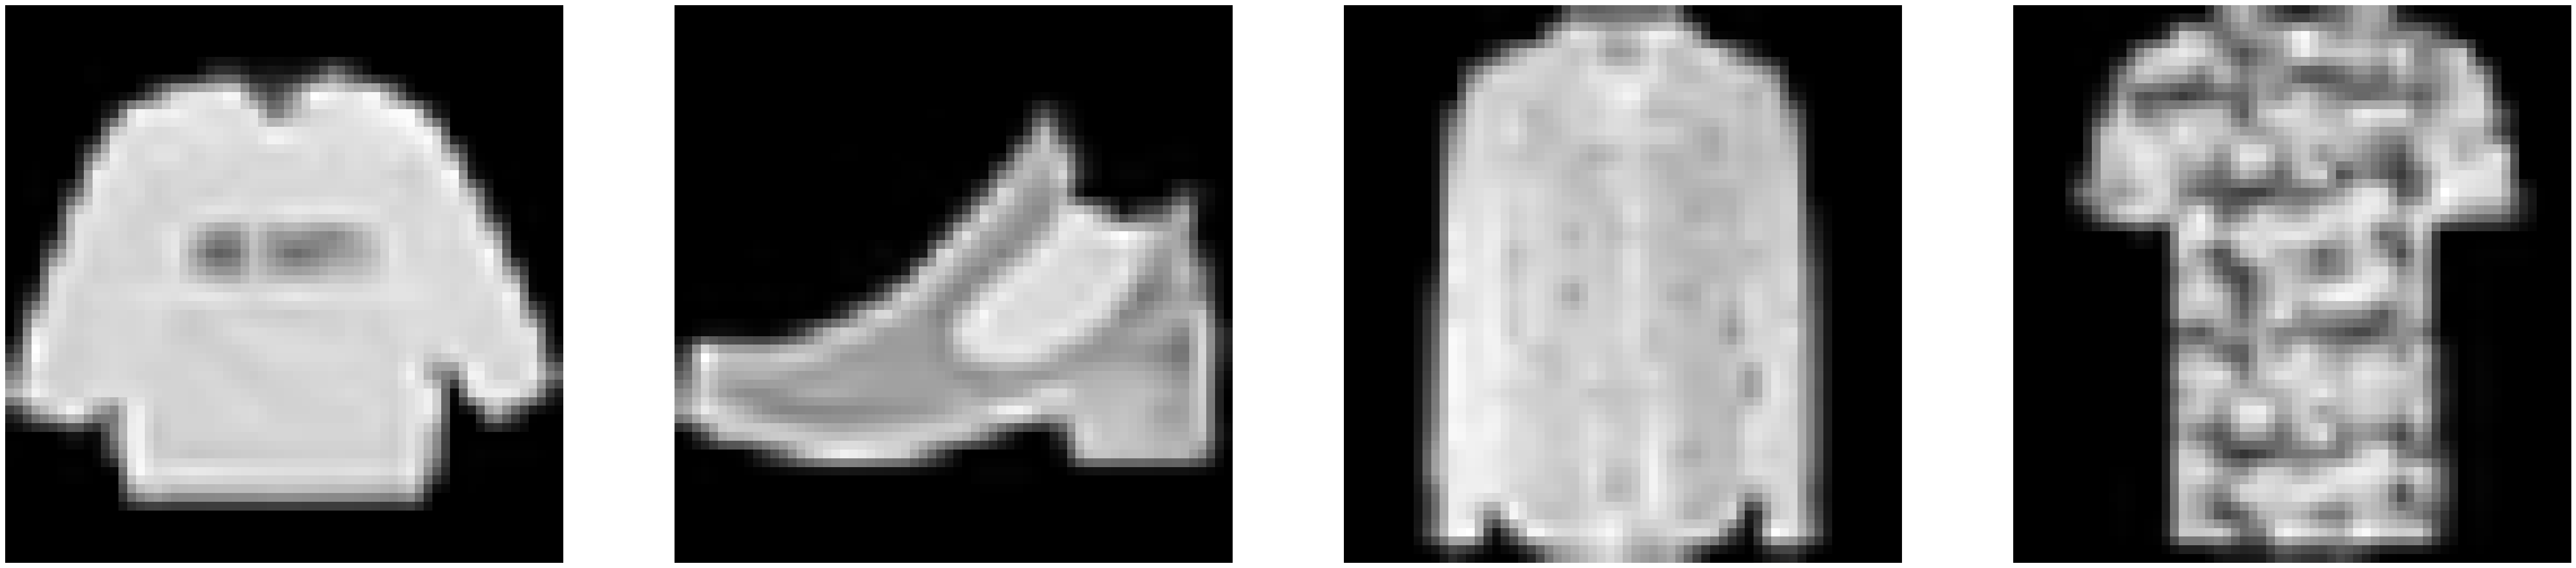

In [ ]:
# sanity check on images in the first minibatch
fig, axes = plt.subplots(1, len(batch), figsize=(IMAGE_SIZE, IMAGE_SIZE))

for i, ax in zip(range(0, len(batch)), axes):
  image = batch[i]
  image = image.numpy()
  image = image.squeeze()
  ax.imshow(image, cmap='gray')  # Assuming grayscale images
  ax.axis('off')

plt.show()

The following class defines the architecutre for our generator model.  Our input is a noise vector of dimension 256, and our output is a 64x64 image that resembles one of the images in the training set.  We need to upsample z to a valid image.  To do so, we use transposed convolution, which is essentialy the inverse of convolution.  Transposed convolution uses a kernel like regular convolution but inserts zeroes between the input values during the computation.  The transposed convolutional kernel slides over the input, performing the multiplication and summing operations like in regular convolution but with these added empty spaces.

Some other architectural choices that deal with some of the difficulties of GAN training:
- Using ConvTranspose2d for upsampling helps avoid sparse gradients which slow training and inhibit the model from learning.
- Similarly using a LeakyReLU helps avoid sparse gradients over the regular ReLU function.
- BatchNorm normalizes the activations of each layer which helps improve training stability.  It also acts as a form of regularization by adding noise to the activations through the normalization process.  This helps prevent overfitting in image generation.

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_channels, image_channels, features):
        super(Generator, self).__init__()

        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(noise_channels, features*16, kernel_size=4, stride=1, padding=0),
            nn.LeakyReLU(0.2),
        )

        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(features*16, features*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*8),
            nn.LeakyReLU(0.2),
        )

        self.block3 = nn.Sequential(
            nn.ConvTranspose2d(features*8, features*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*4),
            nn.LeakyReLU(0.2),
        )

        self.block4 = nn.Sequential(
            nn.ConvTranspose2d(features*4, features*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*2),
            nn.LeakyReLU(0.2),
        )

        self.block5 = nn.Sequential(
            nn.ConvTranspose2d(features*2, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return self.block5(x)

The following class defines the architecture for our discriminator model.  The input is a 64x64 image, and the result is a binary classification predicting weather the image is real or fake.  

Some architectural choices:
- For downsampling, convolution operations yeild more stable training than pooling
- The benefits of BatchNorm and LeakyReLU from the generator hold with the discriminator as well

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, image_channels, features):
        super(Discriminator, self).__init__()


        self.block1 = nn.Sequential(
            nn.Conv2d(image_channels, features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(features, features*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*2),
            nn.LeakyReLU(0.2),
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(features*2, features*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*4),
            nn.LeakyReLU(0.2),
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(features*4, features*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*8),
            nn.LeakyReLU(0.2),
        )

        self.block5 = nn.Sequential(
            nn.Conv2d(features*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return self.block5(x)

In [ ]:
G  = Generator(LATENT_DIM, COLOR_CHANNELS, GEN_FEATURES).to(device)
D = Discriminator(COLOR_CHANNELS, DISC_FEATURES).to(device)

The Adam optimizer has been shown to be the best optimizer to use when training a GAN for most datasets/model architectures.  Additionaly, we choose to use an adaptive learning rate for faster convergence and improved generalization.  This adpative learning rate is controlled through two parameters: beta1 and beta2.  beta1 controls the decay rate for the exponentially weighted moving average of past gradients, and beta2 controls the decay rate for the exponentially weighted moving average of the squared gradients.  In both cases, a higher value means more weight is placed on more recent gradients.  These moving averages are then utilized to adjust the effective learning rate for each parameter.

In [ ]:
gen_optimizer = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
disc_optimizer = optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

In [ ]:
criterion = nn.BCELoss()
G.train()
D.train()

# define a fixed noise for testing
fixed_noise = torch.randn(64, LATENT_DIM, 1, 1).to(device)

# GAN Training Procedure

GAN Training can be notoriously difficult, and there are many modifications we can make to influence the behavior of the training process. The following is the general procedure for GAN training:

For each batch, there are three training steps:
 - Train the discriminator on real data drawn from the training set
 - Train the discriminator on fake data created by the generator
 - Train the generator by generating fake data, passing it through the discriminator, computing the loss based on the discriminator's output, and backpropagating through the discriminator to update the generator.  This is why we need to prevent sparse or weak gradients as the backpropogation through the discriminator dilutes the information the generator recieves.

## GAN Training Modifications

We make the following modifications when training the GAN both with and without gradient clipping:

 - We first train the discriminator on a batch of all real samples and then on a batch of all fake samples (as opposed to interspersing the two).  Separating real and fake batches facilitates the optimization of the discriminator and prevents interference between the updates based on real and fake samples. This separation can lead to more efficient training and better performance.
 - We sample our noise vector from a gassian distribution as opposed to a uniform distribution.  The Gaussian distribution is smooth and continuous, which is advantaous because it encourages the generator to produce continuous outputs that result in more realistic samples.  A uniform distirbution on the other hand can result in uneven coverage of modes and lead to mode collapse.
 - We use 0.9 and 0.1 as our real and fake labels respectively (as opposed to 1 and 0).  This prevents the discriminator from becoming overly confident in its predictions and leads to richer gradients.
 - When training the generator we maximize log(D(G(z))) as opposed to minimizing log(1−D(G(z))).  Although the first formula is commonly used in the literature, it results in vanishing gradients early in the training process, and the second formula works better in practice.

## Gradient Clipping

Gradient clipping is a way to reduce instability during training. It addresses the problem of "exploding gradients": large gradients that cause large-scale parameter updates during training and could potentially lead to model divergance as opposed to convergance.  Gradients are calculated as normal; however, their length is computed before model parameters are updated.  If the length of the gradient vector exceeds a predefined threshold (0.25 in our case, although this is a hyperparameter worth experimenting with) the gradient vector is scaled down so that its length equals the threshold. This scaling ensures that the gradients do not become too large.

Gradient clipping reduces training instability at the cost of potentially generating vanishing gradients.  Because gradient clipping limits the norm of the gradients we backpropogate, by the time they reach the generator they might be too small to effectively update the model parameters.  This could adversely impact the quality of generated images.  Therefore, there is a trade off between training stability and the quality of generated images.

### Without Gradient Clipping

In [ ]:
img_list = []
G_losses = []
D_losses = []
step = 0

for epoch in range(EPOCHS):
    for batch_idx, data in enumerate(fasionLoader):
        # set the data to cuda
        data = data.to(device)

        # get the batch size
        batch_size = data.shape[0]

        # Train the discriminator model on real data
        D.zero_grad()
        label = (torch.ones(batch_size) * 0.9).to(device)
        output = D(data).reshape(-1)
        real_disc_loss = criterion(output, label)

        # train the disc model on fake data
        noise = torch.randn(batch_size, LATENT_DIM, 1, 1).to(device) # drawn from a gaussian distribution
        fake = G(noise)
        label = (torch.ones(batch_size) * 0.1).to(device)
        # need to detatch so we don't update the generator based on how well the discriminator classifies images
        output = D(fake.detach()).reshape(-1)
        fake_disc_loss = criterion(output, label)

        # calculate the combined discriminator loss
        disc_loss = real_disc_loss + fake_disc_loss

        # apply the optimizer and gradient for the discriminator
        disc_loss.backward()
        disc_optimizer.step()

        # train the generator model
        G.zero_grad()
        label = torch.ones(batch_size).to(device) # use the real label because we want to maximize log(D(G(z))) not minimize 1 - log(D(G(z)))
        output = D(fake).reshape(-1)
        gen_loss = criterion(output, label)

        # backpropogate discriminator loss to the generator - note we don't call detach() on fake in this part of the training loop
        gen_loss.backward()
        gen_optimizer.step()

        # print losses to console and save them to be plotted
        if batch_idx % 50 == 0:
            print(f"Epoch: {epoch} ===== Batch: {batch_idx}/{len(fasionLoader)} ===== Disc loss: {disc_loss:.4f} ===== Gen loss: {gen_loss:.4f}")
            G_losses.append(gen_loss.item())
            D_losses.append(disc_loss.item())

        # save fake images for comparison with real images later
        if (step % 500 == 0) or ((epoch == EPOCHS-1) and (batch_idx == len(fasionLoader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        step += 1

Epoch: 0 ===== Batch: 0/274 ===== Disc loss: 1.3878 ===== Gen loss: 5.1920
Epoch: 0 ===== Batch: 50/274 ===== Disc loss: 0.6949 ===== Gen loss: 2.3882
Epoch: 0 ===== Batch: 100/274 ===== Disc loss: 1.0694 ===== Gen loss: 1.2480
Epoch: 0 ===== Batch: 150/274 ===== Disc loss: 1.6970 ===== Gen loss: 2.0166
Epoch: 0 ===== Batch: 200/274 ===== Disc loss: 1.0711 ===== Gen loss: 1.3882
Epoch: 0 ===== Batch: 250/274 ===== Disc loss: 1.0640 ===== Gen loss: 2.1277
Epoch: 1 ===== Batch: 0/274 ===== Disc loss: 1.0911 ===== Gen loss: 1.0134
Epoch: 1 ===== Batch: 50/274 ===== Disc loss: 1.1597 ===== Gen loss: 1.3161
Epoch: 1 ===== Batch: 100/274 ===== Disc loss: 1.1609 ===== Gen loss: 1.5812
Epoch: 1 ===== Batch: 150/274 ===== Disc loss: 1.2637 ===== Gen loss: 1.0367
Epoch: 1 ===== Batch: 200/274 ===== Disc loss: 1.2103 ===== Gen loss: 1.9522
Epoch: 1 ===== Batch: 250/274 ===== Disc loss: 0.8854 ===== Gen loss: 1.6366
Epoch: 2 ===== Batch: 0/274 ===== Disc loss: 1.0145 ===== Gen loss: 1.7453
Epoch: 

The graph below illustrates the training loss plotted against training iterations. The training exhibits significant instability, with fluctuations often exceeding a magnitude of 2. Moreover, these fluctuations tend to increase in magnitude as the training progresses.  With no measures to improve training stability, this GAN's training is highly unpredictable.

This unpredictability is a common issue when training a GAN and inherent with the adversarial nature of GAN training.  Some potential solutions outside of gradient clipping are:
- Network Architecture and Hyperparameter Tuning: Testing different network architectures and hyperparameters can allow us to find the architecture/values that work best for our task and facilitate convergence.
- Label Smoothing: Instead of using a fixed value for the real/fake labels, we could slightly randomize the target labels. This can prevent the discriminator from becoming overconfident and destabilizing the training process.  


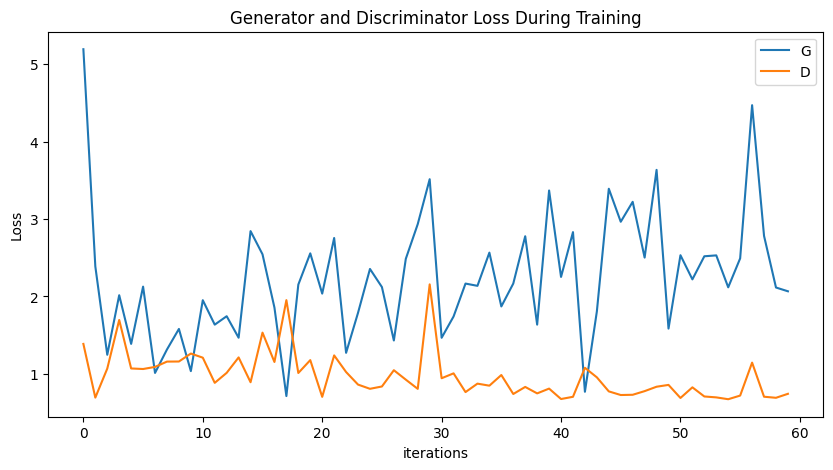

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

However, the generated image quality is quite high.  Although the images are not perfect, they are good approximations of the real images given the limited computational resources and training epochs I had when creating this project.  Notably, we see a wide variety of classes, including dresses, shirts, pullovers, pants, handbags, and shoes (with different styles of each class included as well).  This is a promising sign that mode collapse has not occured.

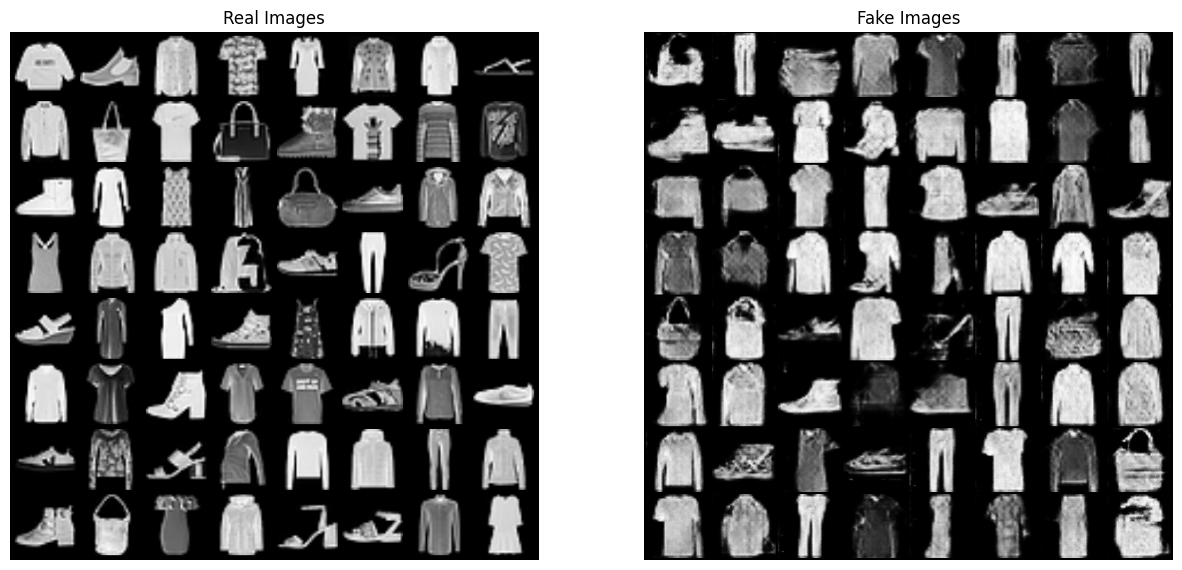

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(fasionLoader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

### With Gradient Clipping

In [ ]:
# Reconstruct all model/optimizer objects to have fresh copies to train with gradient clipping
G  = Generator(LATENT_DIM, COLOR_CHANNELS, GEN_FEATURES).to(device)
D = Discriminator(COLOR_CHANNELS, DISC_FEATURES).to(device)

gen_optimizer = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
disc_optimizer = optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

criterion = nn.BCELoss()
G.train()
D.train()

# define a fixed noise for testing
fixed_noise = torch.randn(64, LATENT_DIM, 1, 1).to(device)

In [ ]:
img_list = []
G_losses = []
D_losses = []
step = 0

for epoch in range(EPOCHS):
    for batch_idx, data in enumerate(fasionLoader):
        # set the data to cuda
        data = data.to(device)

        # get the batch size
        batch_size = data.shape[0]

        # Train the discriminator model on real data
        D.zero_grad()
        label = (torch.ones(batch_size) * 0.9).to(device)
        output = D(data).reshape(-1)
        real_disc_loss = criterion(output, label)

        # train the disc model on fake data
        noise = torch.randn(batch_size, LATENT_DIM, 1, 1).to(device) # drawn from a gaussian distribution
        fake = G(noise)
        label = (torch.ones(batch_size) * 0.1).to(device)
        # need to detatch so we don't update the generator based on how well the discriminator classifies images
        output = D(fake.detach()).reshape(-1)
        fake_disc_loss = criterion(output, label)

        # calculate the combined discriminator loss
        disc_loss = real_disc_loss + fake_disc_loss

        # apply the optimizer and gradient for the discriminator
        disc_loss.backward()

        # gradient clipping for the discriminator
        utils.clip_grad_norm_(D.parameters(), max_norm=0.25)

        disc_optimizer.step()

        # train the generator model
        G.zero_grad()
        label = torch.ones(batch_size).to(device) # use the real label because we want to maximize log(D(G(z))) not minimize 1 - log(D(G(z)))
        output = D(fake).reshape(-1)
        gen_loss = criterion(output, label)

        # backpropogate discriminator loss to the generator - note we don't call detach() on fake in this part of the training loop
        gen_loss.backward()

        # gradient clipping for the generator
        utils.clip_grad_norm_(G.parameters(), max_norm=0.25)

        gen_optimizer.step()

        # print losses to console and save them to be plotted
        if batch_idx % 50 == 0:
            print(f"Epoch: {epoch} ===== Batch: {batch_idx}/{len(fasionLoader)} ===== Disc loss: {disc_loss:.4f} ===== Gen loss: {gen_loss:.4f}")
            G_losses.append(gen_loss.item())
            D_losses.append(disc_loss.item())

        # save fake images for comparison with real images later
        if (step % 500 == 0) or ((epoch == EPOCHS-1) and (batch_idx == len(fasionLoader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        step += 1

Epoch: 0 ===== Batch: 0/274 ===== Disc loss: 0.6545 ===== Gen loss: 2.4484
Epoch: 0 ===== Batch: 50/274 ===== Disc loss: 0.6540 ===== Gen loss: 3.4493
Epoch: 0 ===== Batch: 100/274 ===== Disc loss: 0.7452 ===== Gen loss: 1.7741
Epoch: 0 ===== Batch: 150/274 ===== Disc loss: 0.6581 ===== Gen loss: 2.2088
Epoch: 0 ===== Batch: 200/274 ===== Disc loss: 0.7209 ===== Gen loss: 2.6344
Epoch: 0 ===== Batch: 250/274 ===== Disc loss: 0.6606 ===== Gen loss: 2.8005
Epoch: 1 ===== Batch: 0/274 ===== Disc loss: 0.6690 ===== Gen loss: 2.5919
Epoch: 1 ===== Batch: 50/274 ===== Disc loss: 0.6707 ===== Gen loss: 2.7360
Epoch: 1 ===== Batch: 100/274 ===== Disc loss: 0.6630 ===== Gen loss: 1.8566
Epoch: 1 ===== Batch: 150/274 ===== Disc loss: 0.6749 ===== Gen loss: 2.4173
Epoch: 1 ===== Batch: 200/274 ===== Disc loss: 0.6583 ===== Gen loss: 2.7387
Epoch: 1 ===== Batch: 250/274 ===== Disc loss: 0.6559 ===== Gen loss: 2.9467
Epoch: 2 ===== Batch: 0/274 ===== Disc loss: 0.6520 ===== Gen loss: 2.9837
Epoch: 

The below loss graph shows far more stability than the loss graph without gradient clipping.  The loss for this training does not exceed 3.5, and swings rarely have magnitude greater than one.  Additionally, swings occur less frequently, especially for the discriminator.  Interestingly, there appears to be a moment where the generator's generating ability overtakes the discriminator's ability to distinguish between real and fake images.  Enchanced training stability facilates more persistent dynamics like this as opposed to the erratic swings of the previous training graph.

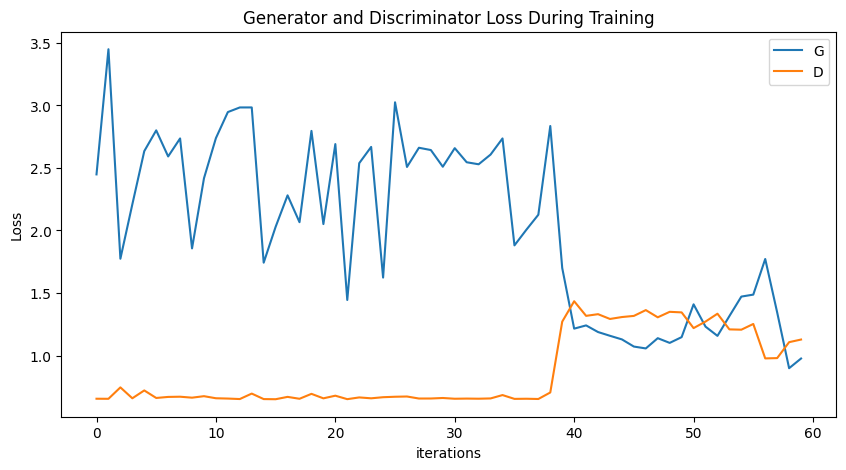

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

However, this improved training stability comes at the cost of generated image quality. The generated images are far less realistic emulations of the origional training images.  Additionally, we see fewer classes of clothes than we did in the previous training.  This is likely due to gradient clipping limiting the information the generatoe can learn from.  Perhaps more training epochs would allow this generator to match the generation capacity of the generator without gradient clipping; however, I do not have the computational resources to do this.

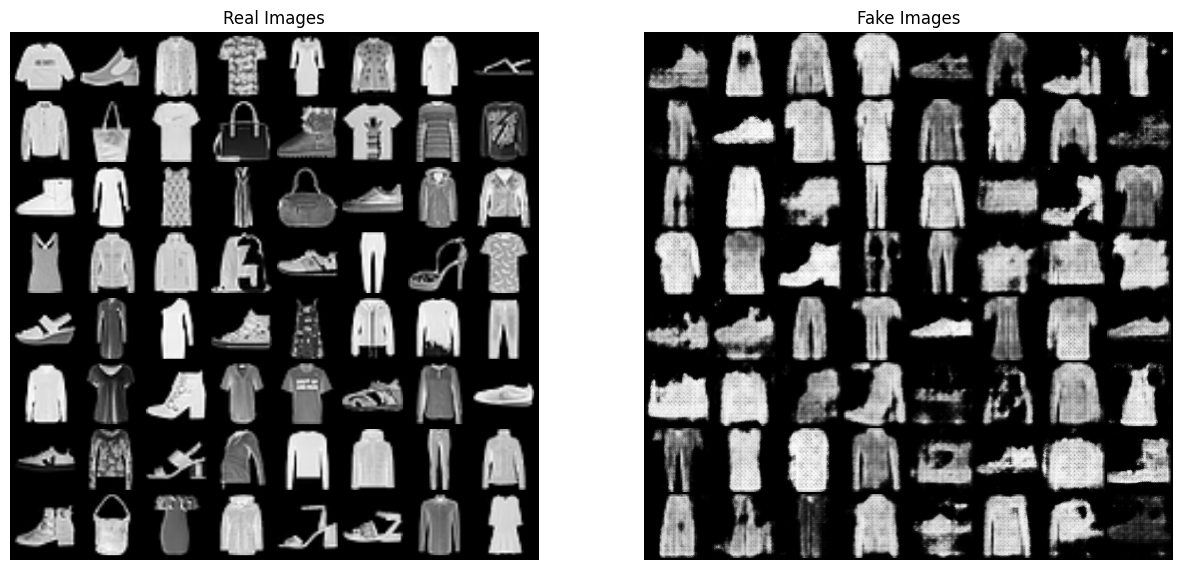

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(fasionLoader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()